In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_CLASSES = 8
EPOCHS = 50
# replace the data path with yours
train_data_dir = r"C:\Users\Pavithran\Desktop\Datasets\ODIR\ODIR-5K\ODIR-5K\Final training images\left-right"
test_data_dir = r"C:\Users\Pavithran\Desktop\Datasets\ODIR\ODIR-5K\ODIR-5K\Final test images\left-right"

def self_attentive_gan(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    model = models.Model(inputs=inputs, outputs=x, name='self_attentive_gan')
    model.summary()
    return model

def cnn_with_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=x, name='cnn_with_discriminator')
    model.summary()
    return model

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

input_shape = (*IMAGE_SIZE, 3)
sa_gan_model = self_attentive_gan(input_shape)

reshaped_output = layers.Reshape((32, 32, 256))(sa_gan_model.output)
cnn_discriminator_model = cnn_with_discriminator((32, 32, 256))

combined_model = models.Sequential([
    sa_gan_model,
    layers.Reshape((32, 32, 256)),
    cnn_discriminator_model,
    layers.Dense(NUM_CLASSES, activation='softmax')
])

combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

history = combined_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

test_loss, test_accuracy = combined_model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

Found 5120 images belonging to 8 classes.
Found 1272 images belonging to 8 classes.


Model: "self_attentive_gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_77 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_78 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_78 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_79 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_79 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 370,816 (1.41 MB)

 Trainable params: 370,816 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Model: "cnn_with_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)          │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 16, 16, 64)          │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_80 (LeakyReLU)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_81 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_81 (LeakyReLU)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_82 (LeakyReLU)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,614,721 (9.97 MB)

 Trainable params: 2,614,721 (9.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.3288 - loss: 1.7406 - val_accuracy: 0.5228 - val_loss: 1.5303
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.4340 - loss: 1.5743 - val_accuracy: 0.5228 - val_loss: 1.5326
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.4286 - loss: 1.5610 - val_accuracy: 0.5228 - val_loss: 1.5309
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.4369 - loss: 1.5494 - val_accuracy: 0.5228 - val_loss: 1.5313
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.4401 - loss: 1.5622 - val_accuracy: 0.5228 - val_loss: 1.5445
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4208 - loss: 1.5812 - val_accuracy: 0.5228 - val_loss: 1.5330
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.4246 - loss: 1.5758 - val_accuracy: 0.5228 - val_loss: 1.5220
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4248 - loss: 1.5889 - val_accu

In [37]:
# replace path to save model as keras
model.save(r"C:\Users\Pavithran\Desktop\Jupyter\combined_model.keras")

In [35]:
from tensorflow.keras.preprocessing import image

class_labels = [ "AMD", "Cataract","Diabetic", "Glaucoma", "Hypertension", "Myopia","Normal","Others"]

model = combined_model
#replace the image paths
input_image_paths = [r"C:\Users\Pavithran\Desktop\Datasets\ODIR\ODIR-5K\ODIR-5K\Final training images\left-right\Normal\1_left.jpg", r"C:\Users\Pavithran\Desktop\Datasets\ODIR\ODIR-5K\ODIR-5K\Final training images\left-right\Normal\1_left.jpg"]
input_images = []
for img_path in input_image_paths:
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    input_images.append(img_array)

input_images = np.vstack(input_images)
predictions = model.predict(input_images)

predicted_classes = np.argmax(predictions, axis=1)
predicted_categories = [class_labels[predicted_class] for predicted_class in predicted_classes]

for img_path, predicted_category in zip(input_image_paths, predicted_categories):
    print(f"Image: {img_path}, Predicted Category: {predicted_category}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: C:\Users\Pavithran\Desktop\Datasets\ODIR\ODIR-5K\ODIR-5K\Final training images\left-right\Normal\1_left.jpg, Predicted Category: Normal
Image: C:\Users\Pavithran\Desktop\Datasets\ODIR\ODIR-5K\ODIR-5K\Final training images\left-right\Normal\1_left.jpg, Predicted Category: Normal


40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 655ms/step
F1 Score: 0.358968676842553
AUC Score: 0.5


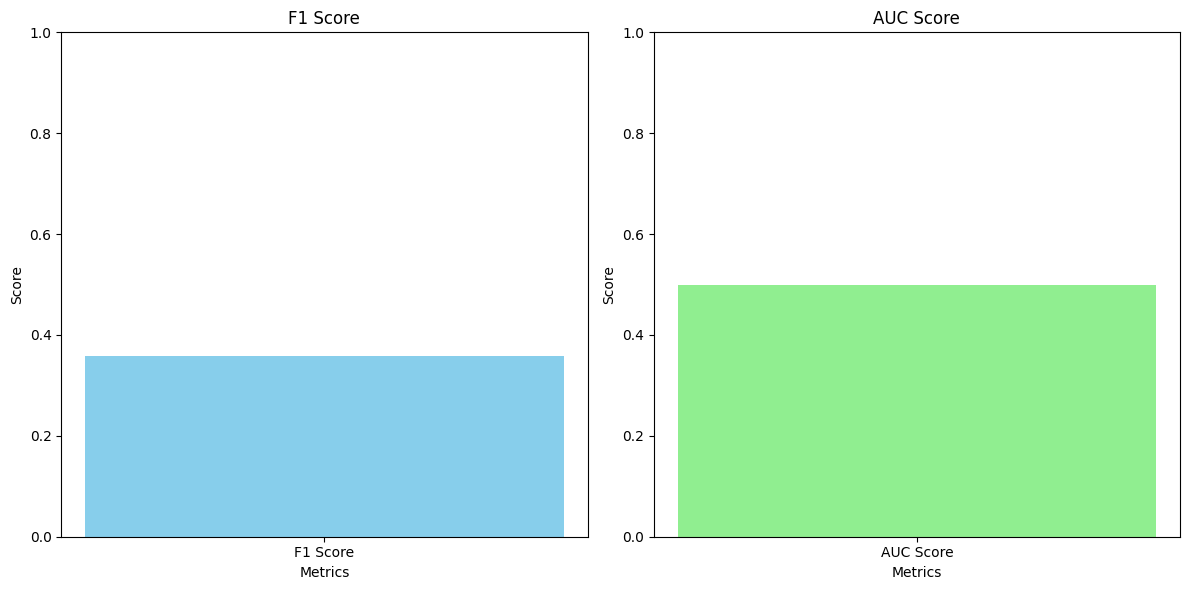

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
y_pred = combined_model.predict(test_generator)
y_true = test_generator.classes
f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')
print("F1 Score:", f1)
auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
print("AUC Score:", auc)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(['F1 Score'], [f1], color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('F1 Score')
plt.ylim(0, 1)
plt.subplot(1, 2, 2)
plt.bar(['AUC Score'], [auc], color='lightgreen')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('AUC Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [38]:
import os

In [40]:
os.getcwd()

'C:\\Users\\Pavithran\\Desktop\\Jupyter'